In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import functools
import operator
import os
import swifter
import collections
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler, LabelEncoder
from nltk.tokenize import word_tokenize
pd.set_option('display.max_colwidth', -1)
file = "cleaned_data.csv"
SEED=32


In [2]:
nlp = ['Package Name', 'Destination', 'Itinerary', 'Places Covered', 'Hotel Details', 'Airline',
       'Sightseeing Places Covered']
cat_cols = ['Package Type', 'Start City', 'Cancellation Rules']
reg_cols = ['Flight Stops', 'Meals', 'destination_count',
       'airlines_count', 'sightseeing_count', 'hotel_details_count',
       'place_covered_count', 'itinerary_count', 'package_name_length']
date_col = 'Travel Date'
target_col = 'Per Person Price'

In [3]:
df = pd.read_csv(file, parse_dates=['Travel Date'])
df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Sightseeing Places Covered,Cancellation Rules,Per Person Price,destination_count,airlines_count,sightseeing_count,hotel_details_count,place_covered_count,itinerary_count,package_name_length
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chandigarh,New Delhi|Shimla|Manali|Chandigarh,2021-07-30,Not Available,Mumbai,Not Available,...,Not Available,Not Available,11509.0,4,1,1,1,4,4,8
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,2021-08-12,The Orchard Retreat & Spa:4.6|WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group:4.1|The Orchard Retreat & Spa:4.6,New Delhi,IndiGo|IndiGo,...,Dal Lake | Avantipura Ruins | Mughal Gardens | Cheshma Shahi | Nishat Bagh | Shalimar Garden | Shankaracharya Temple,Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.,22485.5,3,2,7,3,3,3,3
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,2021-04-26,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,Lake Pichola | Jag Mandir Palace | Saheliyon ki Bari | Maharana Pratap Smarak | Vintage Car Museum | City Palace | Crystal Gallery | Chittorgarh Fort,Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.,12421.5,2,1,8,2,2,2,6
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kovalam and Poovar,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2021-08-27,"Elixir Hills Suites Resort & Spa-MMT Holidays Special:4.6|The Zuri Kumarakom, Kerala Resort & Spa:4.6|Marari Beach - CGH Earth:4.3|Estuary Sarovar Portico:",New Delhi,IndiGo,...,Mattupetty Dam | Echo Point | Tata Tea Museum | Pothamedu View Point | Lakkam Waterfalls | Eravikulam national park | Rose Garden | Kumarakom Bird Sanctuary | Pathiramanal Island,Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.,35967.0,4,1,9,4,4,4,6
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,2021-12-12,Dusit Thani Pattaya - MMT Special:4.5|Amari Watergate Hotel Bangkok - MMT Special:4.2,New Delhi,Spicejet|Go Air,...,"Coral Island Tour with Indian 

In [4]:
def get_nights(x):
    x = x.lower().split(' . ')
    s = 0
    for i in x:
        assert len(i) > 0
        assert len(i.split(' ')[0]) == 2 and  i.split(' ')[0][1] == 'n'
        s += int(i.split(' ')[0][0])
    return s

    

# straight strings ['Package Name']

In [5]:

class StraightString(object):
    def __init__(self, vector_size, window, epochs):
        self.vector_size = vector_size
        self.window = window
        self.epochs = epochs
    
    def train(self, string_array, separator=None, double_word=False):
        string_array = [i.replace('-', ' ') for i in string_array]
        if not separator:
            documents = [TaggedDocument(words=_d.lower().split(), tags=[str(i)]) for i, _d in enumerate(string_array)]
        elif double_word:
            assert separator
            documents = [TaggedDocument(words=_d.lower().replace(separator, ' ').split(), tags=[str(i)]) for i, _d in enumerate(string_array)]
        else:
            documents = [TaggedDocument(words=_d.lower().split(separator), tags=[str(i)]) for i, _d in enumerate(string_array)]
        print(documents[:10], len(documents))
        model = Doc2Vec(
            vector_size=self.vector_size,
            seed=SEED,
            window=self.window,
            epocs=self.epochs,
            workers=4,
            min_count=1
        )
        model.build_vocab(documents)
        model.train(documents, total_examples=model.corpus_count, epochs=model.iter)
        return model

def doc_2_vec_features(m, x):
    return tuple(m.infer_vector(word_tokenize(x.lower())))

In [6]:

model = StraightString(10, 10, 100).train(df['Package Name'].values)
df['package_name_0'], df['package_name_1'], df['package_name_2'], df['package_name_3'], df['package_name_4'],\
df['package_name_5'], df['package_name_6'], df['package_name_7'], df['package_name_8'], df['package_name_9']\
= zip(*(df['Package Name'].progress_apply(lambda x: doc_2_vec_features(model, x))))

[TaggedDocument(words=['best', 'of', 'shimla', 'and', 'manali', 'holiday', 'from', 'delhi'], tags=['0']), TaggedDocument(words=['kashmir', 'valley', 'vacation'], tags=['1']), TaggedDocument(words=['might', 'of', 'mewar', 'udaipur', 'and', 'chittorgarh'], tags=['2']), TaggedDocument(words=['colorful', 'kerala', '(', 'romantic', 'getaway', ')'], tags=['3']), TaggedDocument(words=['a', 'week', 'in', 'bangkok', '&', 'pattaya'], tags=['4']), TaggedDocument(words=['cochin', 'trip', 'with', 'visit', 'to', 'guruvayoor', 'temple'], tags=['5']), TaggedDocument(words=['jaipur', 'holiday'], tags=['6']), TaggedDocument(words=['kasol', '&', 'manali', 'holiday', 'from', 'delhi'], tags=['7']), TaggedDocument(words=['charismatic', 'kashmir', 'with', 'gulmarg'], tags=['8']), TaggedDocument(words=['luxury', 'getaway', 'to', 'udaipur', 'stay', 'at', 'the', 'chunda', 'palace', 'hotel'], tags=['9'])] 30000


/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


  0%|          | 0/30000 [00:00<?, ?it/s]

# straight strings separated by a separator ['Destination', 'Places Covered', 'Hotel Details','Sightseeing Places Covered']

# combination of strings and numbers separated by a separator ['Itinerary']

In [7]:
# need to wok on itinerrary features, include total nights, etc

model = StraightString(4, 4, 50).train(df['Destination'].values, separator='|')
df['destination_0'], df['destination_1'], df['destination_2'], df['destination_3']\
= zip(*(df['Destination'].progress_apply(lambda x: doc_2_vec_features(model, x))))



model = StraightString(4, 4, 50).train(df['Places Covered'].values, separator='|')
df['places_covered_0'], df['places_covered_1'], df['places_covered_2'], df['places_covered_3']\
= zip(*(df['Places Covered'].progress_apply(lambda x: doc_2_vec_features(model, x))))


model = StraightString(4, 4, 50).train(df['Sightseeing Places Covered'].values, separator=' | ')
df['sight_seeing_places_covered_0'], df['sight_seeing_places_covered_1'], df['sight_seeing_places_covered_3'],\
df['sight_seeing_places_covered_4']\
= zip(*(df['Sightseeing Places Covered'].progress_apply(lambda x: doc_2_vec_features(model, x))))




model = StraightString(4, 4, 50).train(df['Itinerary'].values, separator=' . ')
df['itinerary_0'], df['itinerary_1'], df['itinerary_2'], df['itinerary_3']\
= zip(*(df['Itinerary'].progress_apply(lambda x: doc_2_vec_features(model, x))))



model = StraightString(8, 8, 100).train(df['Hotel Details'].values, separator='|', double_word=True)
df['hotel_details_0'], df['hotel_details_1'], df['hotel_details_2'], df['hotel_details_3'], df['hotel_details_4'],\
df['hotel_details_5'], df['hotel_details_6'], df['hotel_details_7']\
= zip(*(df['Hotel Details'].progress_apply(lambda x: doc_2_vec_features(model, x))))

[TaggedDocument(words=['new delhi', 'shimla', 'manali', 'chandigarh'], tags=['0']), TaggedDocument(words=['srinagar', 'pahalgam', 'srinagar'], tags=['1']), TaggedDocument(words=['udaipur', 'chittorgarh'], tags=['2']), TaggedDocument(words=['munnar', 'kumarakom', 'allepey', 'kovalam and poovar'], tags=['3']), TaggedDocument(words=['pattaya', 'bangkok'], tags=['4']), TaggedDocument(words=['cochin'], tags=['5']), TaggedDocument(words=['jaipur'], tags=['6']), TaggedDocument(words=['kasol', 'manali'], tags=['7']), TaggedDocument(words=['srinagar', 'gulmarg', 'pahalgam', 'srinagar'], tags=['8']), TaggedDocument(words=['udaipur'], tags=['9'])] 30000


/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


  0%|          | 0/30000 [00:00<?, ?it/s]

[TaggedDocument(words=['new delhi', 'shimla', 'manali', 'chandigarh'], tags=['0']), TaggedDocument(words=['srinagar', 'pahalgam', 'srinagar'], tags=['1']), TaggedDocument(words=['udaipur', 'chittorgarh'], tags=['2']), TaggedDocument(words=['munnar', 'kumarakom', 'allepey', 'kovalam and poovar'], tags=['3']), TaggedDocument(words=['pattaya', 'bangkok'], tags=['4']), TaggedDocument(words=['cochin'], tags=['5']), TaggedDocument(words=['jaipur'], tags=['6']), TaggedDocument(words=['kasol', 'manali'], tags=['7']), TaggedDocument(words=['srinagar', 'gulmarg', 'pahalgam', 'srinagar'], tags=['8']), TaggedDocument(words=['udaipur'], tags=['9'])] 30000


  0%|          | 0/30000 [00:00<?, ?it/s]

[TaggedDocument(words=['not available'], tags=['0']), TaggedDocument(words=[' dal lake', 'avantipura ruins', 'mughal gardens', 'cheshma shahi', 'nishat bagh', 'shalimar garden', 'shankaracharya temple '], tags=['1']), TaggedDocument(words=[' lake pichola', 'jag mandir palace', 'saheliyon ki bari', 'maharana pratap smarak', 'vintage car museum', 'city palace', 'crystal gallery', 'chittorgarh fort '], tags=['2']), TaggedDocument(words=[' mattupetty dam', 'echo point', 'tata tea museum', 'pothamedu view point', 'lakkam waterfalls', 'eravikulam national park', 'rose garden', 'kumarakom bird sanctuary', 'pathiramanal island '], tags=['3']), TaggedDocument(words=[' coral island tour with indian lunch, join speed boat by shared transfer', 'hotel in pattaya to hotel in bangkok by shared transfer '], tags=['4']), TaggedDocument(words=[' dutch palace', 'jewish synagogue', 'st. francis church', 'chinese fishing nets', 'day excursion to guruvayoor (with transfers) '], tags=['5']), TaggedDocument(w

  0%|          | 0/30000 [00:00<?, ?it/s]

[TaggedDocument(words=['1n new delhi', '2n shimla', '2n manali', '1n chandigarh'], tags=['0']), TaggedDocument(words=['1n srinagar', '2n pahalgam', '1n srinagar'], tags=['1']), TaggedDocument(words=['2n udaipur', '1n chittorgarh'], tags=['2']), TaggedDocument(words=['2n munnar', '1n kumarakom', '1n allepey', '2n kovalam and poovar'], tags=['3']), TaggedDocument(words=['4n pattaya', '3n bangkok'], tags=['4']), TaggedDocument(words=['2n cochin'], tags=['5']), TaggedDocument(words=['3n jaipur'], tags=['6']), TaggedDocument(words=['2n kasol', '3n manali'], tags=['7']), TaggedDocument(words=['1n srinagar', '1n gulmarg', '2n pahalgam', '2n srinagar'], tags=['8']), TaggedDocument(words=['2n udaipur'], tags=['9'])] 30000


  0%|          | 0/30000 [00:00<?, ?it/s]

[TaggedDocument(words=['not', 'available'], tags=['0']), TaggedDocument(words=['the', 'orchard', 'retreat', '&', 'spa:4.6', 'welcomhotel', 'pine', 'n', 'peak', 'pahalgam', 'member', 'itc', 'hotel', 'group:4.1', 'the', 'orchard', 'retreat', '&', 'spa:4.6'], tags=['1']), TaggedDocument(words=['the', 'ananta:4.4', 'justa', 'lake', 'nahargarh', 'palace:4'], tags=['2']), TaggedDocument(words=['elixir', 'hills', 'suites', 'resort', '&', 'spa', 'mmt', 'holidays', 'special:4.6', 'the', 'zuri', 'kumarakom,', 'kerala', 'resort', '&', 'spa:4.6', 'marari', 'beach', 'cgh', 'earth:4.3', 'estuary', 'sarovar', 'portico:'], tags=['3']), TaggedDocument(words=['dusit', 'thani', 'pattaya', 'mmt', 'special:4.5', 'amari', 'watergate', 'hotel', 'bangkok', 'mmt', 'special:4.2'], tags=['4']), TaggedDocument(words=['not', 'available'], tags=['5']), TaggedDocument(words=['ratnawali', 'a', 'vegetarian', 'heritage', 'hotel:4.1'], tags=['6']), TaggedDocument(words=['the', 'himalayan', 'village:four', 'the', 'holida

  0%|          | 0/30000 [00:00<?, ?it/s]

# categorical values separated by a separator ['Airline']

In [8]:
airlines = ['PAD']
for i in df.Airline:
    airlines.extend(i.split("|"))

airline_encoder = LabelEncoder()
airline_encoder.fit(airlines)
def padded_keywords(s):  
    lst = s.split("|")
    
    if len(lst) <= 5:
        ret = ['PAD'] * (5 - len(lst))
        ret.extend(lst)
    else:
        ret = lst[-5:]
    assert len(ret) == 5
    return airline_encoder.transform([ret[0]])[0], airline_encoder.transform([ret[1]])[0], airline_encoder.transform([ret[2]])[0], \
    airline_encoder.transform([ret[3]])[0], airline_encoder.transform([ret[4]])[0]
df['airline_0'] , df['airline_1'], df['airline_2'], df['airline_3'], df['airline_4']\
= zip(*df['Airline'].apply(padded_keywords))


In [9]:

df['Itinerary_night_count'] = df['Itinerary'].apply(get_nights)
df.drop(columns=nlp, inplace=True)

# categorical  cols

In [10]:
for col in tqdm(cat_cols):
    df[col] = LabelEncoder().fit_transform(df[col])

  0%|          | 0/3 [00:00<?, ?it/s]

# need to work on time series features

<AxesSubplot:xlabel='Travel Date', ylabel='Per Person Price'>

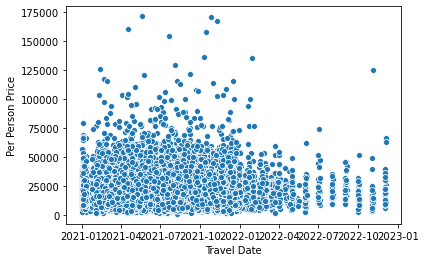

In [11]:
# average price

sns.scatterplot(x=df[~df['Per Person Price'].isna()]['Travel Date'], y=df[~df['Per Person Price'].isna()]['Per Person Price'])

In [12]:
df.sort_values("Travel Date", inplace=True)


In [13]:
df['package_type_price_100'] = df.groupby("Package Type")['Per Person Price'].transform(lambda s: s.rolling(100, min_periods=1).mean())
df['package_type_price_1000'] = df.groupby("Package Type")['Per Person Price'].transform(lambda s: s.rolling(1000, min_periods=1).mean())

In [14]:
df['start_city_price_100'] = df.groupby("Start City")['Per Person Price'].transform(lambda s: s.rolling(100, min_periods=1).mean())
df['start_city_price_1000'] = df.groupby("Start City")['Per Person Price'].transform(lambda s: s.rolling(1000, min_periods=1).mean())

In [15]:
df.drop(columns=['Travel Date'], inplace=True)


In [16]:
df.columns,len(df.columns)

(Index(['Uniq Id', 'Package Type', 'Start City', 'Flight Stops', 'Meals',
        'Cancellation Rules', 'Per Person Price', 'destination_count',
        'airlines_count', 'sightseeing_count', 'hotel_details_count',
        'place_covered_count', 'itinerary_count', 'package_name_length',
        'package_name_0', 'package_name_1', 'package_name_2', 'package_name_3',
        'package_name_4', 'package_name_5', 'package_name_6', 'package_name_7',
        'package_name_8', 'package_name_9', 'destination_0', 'destination_1',
        'destination_2', 'destination_3', 'places_covered_0',
        'places_covered_1', 'places_covered_2', 'places_covered_3',
        'sight_seeing_places_covered_0', 'sight_seeing_places_covered_1',
        'sight_seeing_places_covered_3', 'sight_seeing_places_covered_4',
        'itinerary_0', 'itinerary_1', 'itinerary_2', 'itinerary_3',
        'hotel_details_0', 'hotel_details_1', 'hotel_details_2',
        'hotel_details_3', 'hotel_details_4', 'hotel_details_5'

In [17]:
# df.to_csv("features.csv", index=False)

<AxesSubplot:>

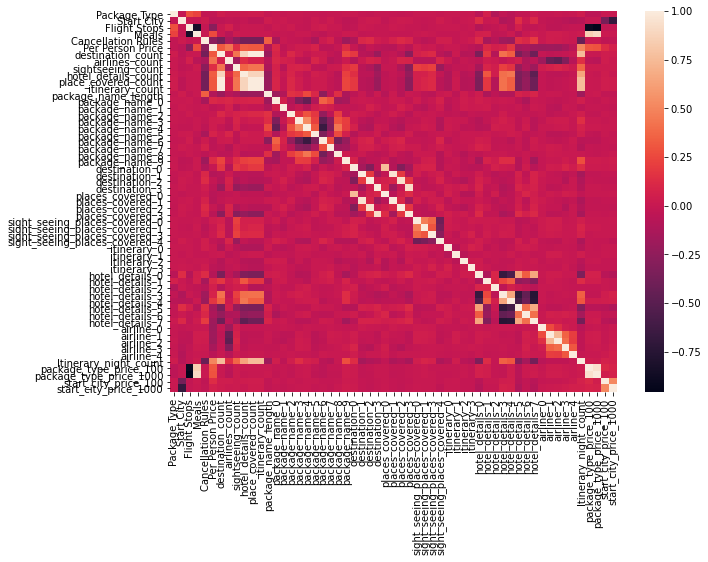

In [18]:
plt.figure(figsize=(10,7))

sns.heatmap(df.corr(method ='pearson'), 
        xticklabels=df.corr(method ='pearson').columns,
        yticklabels=df.corr(method ='pearson').columns)


<AxesSubplot:xlabel='Package Type', ylabel='Per Person Price'>

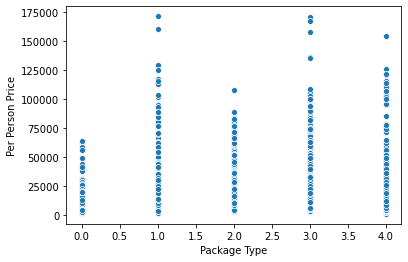

In [19]:
sns.scatterplot(y='Per Person Price', x='Package Type', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='destination_count', ylabel='Per Person Price'>

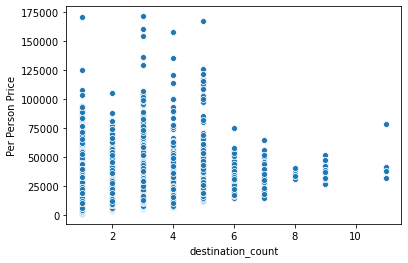

In [20]:
sns.scatterplot(y='Per Person Price', x='destination_count', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='airlines_count', ylabel='Per Person Price'>

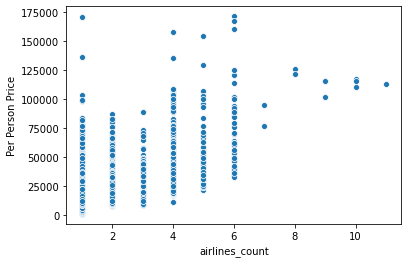

In [21]:
sns.scatterplot(y='Per Person Price', x='airlines_count', data=df[~df['Per Person Price'].isna()])

In [22]:
df.groupby(['Package Type', 'airlines_count']).ngroup()

3393     21
572      26
18048    4 
11995    20
15242    20
         ..
29518    26
7783     14
13089    21
29262    4 
22240    16
Length: 30000, dtype: int64

<AxesSubplot:xlabel='Start City', ylabel='Per Person Price'>

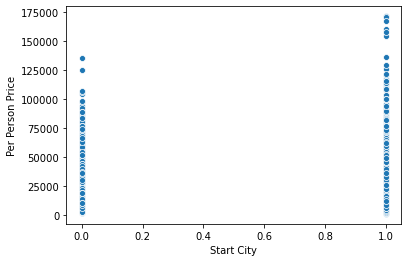

In [23]:
sns.scatterplot(y='Per Person Price', x='Start City', data=df[~df['Per Person Price'].isna()])

In [24]:
df['PT_AC'] = df.groupby(['Package Type', 'airlines_count']).ngroup().astype('int')

df['PT_DC'] = df.groupby(['Package Type', 'destination_count']).ngroup().astype('int')

df['PT_SC'] = df.groupby(['Package Type', 'Start City']).ngroup().astype('int')



In [25]:
df['start_city_mean'] = df.groupby('Start City')['Per Person Price'].transform('mean')
df['start_city_sum'] = df.groupby('Start City')['Per Person Price'].transform('sum')

df['package_type_mean'] = df.groupby("Package Type")['Per Person Price'].transform('mean')
df['package_type_sum'] = df.groupby("Package Type")['Per Person Price'].transform('sum')


In [26]:
df.to_csv("features.csv", index=False)